In [1]:
import numpy as np
import scipy
import pandas as pd
import anndata
import scanpy as sc
import scipy.io
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import os
import scherlock
%matplotlib inline

In [2]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rc('font', size=12)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["image.cmap"] = 'viridis_r'

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_versions()
# sc.settings.set_figure_params(dpi=80, facecolor='white')

In [3]:
#########################
######################### Read the data (pre-annotated) ... or will be
#########################

adata = sc.read_h5ad("reduced/10x_gex.h5ad")

adata.var_names_make_unique()
adata.obs["sampleid"] = "sample1"

# annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var["gene_names"].str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, inplace=True)

# Normalize the counts
sc.pp.normalize_total(adata, target_sum=1e6)    

# Move to log counts
sc.pp.log1p(adata) 

### Store what we have now, somewhat raw (CPM-normalized and pseudo-log)
adata.raw=adata

normalizing counts per cell
    finished (0:00:00)


In [4]:
def findHighlyVariable(adata):
    adata2 = sc.AnnData(X=adata.raw.X, 
                        var=adata.raw.var,
                        obs = adata.obs)
    mitochondrial_genes = adata2.var_names[adata2.var["gene_names"].str.startswith('MT-')].tolist()

    #Figure out the variable genes for the full dataset
    sc.pp.highly_variable_genes(adata2, min_mean=0.5, max_mean=20, min_disp=0.3, batch_key = 'sampleid')
    #sc.pl.highly_variable_genes(adata2)
    
    # Exclude the mitochondrial genes
    for i,g in enumerate(adata2.var.highly_variable.index.values.tolist()):
        if g in mitochondrial_genes:
            adata2.var.highly_variable[g] = False

    #sc.pl.highly_variable_genes(adata2)

    ## Set which genes to consider highly variable
    var_genes = adata2.var.highly_variable[adata2.var.highly_variable == True].copy().index
    adata.var.highly_variable=adata2.var.highly_variable

    return(var_genes)

var_genes=findHighlyVariable(adata)

extracting highly variable genes


... storing 'sampleid' as categorical


    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/mahogny/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mahogny/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [5]:
#Calculate neighbour graph
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata, n_components=3)

computing PCA
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


running Leiden clustering
    finished: found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'sampleid' as categorical
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


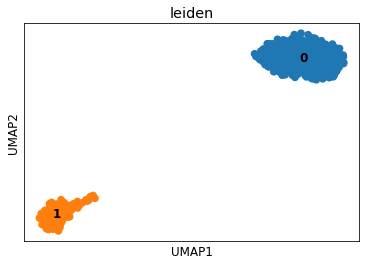

In [6]:
### Perform the clustering
sc.tl.leiden(adata, resolution=0.3)
sc.pl.umap(adata, color=[
    'leiden'], 
    legend_loc = 'on data',
    ncols=2)


In [7]:
### For cellpiles
import scherlock.CellPile as cpl

# Initialize cellpile
cp = cpl.CellPile()

### Load the reference genome
cp.addGTF("reduced/ref/genes.gtf.gz")
cp.addPile("reduced/10x_atac.cellpile", pileName='sample1')  #Note that the pilename must correspond to sampleid


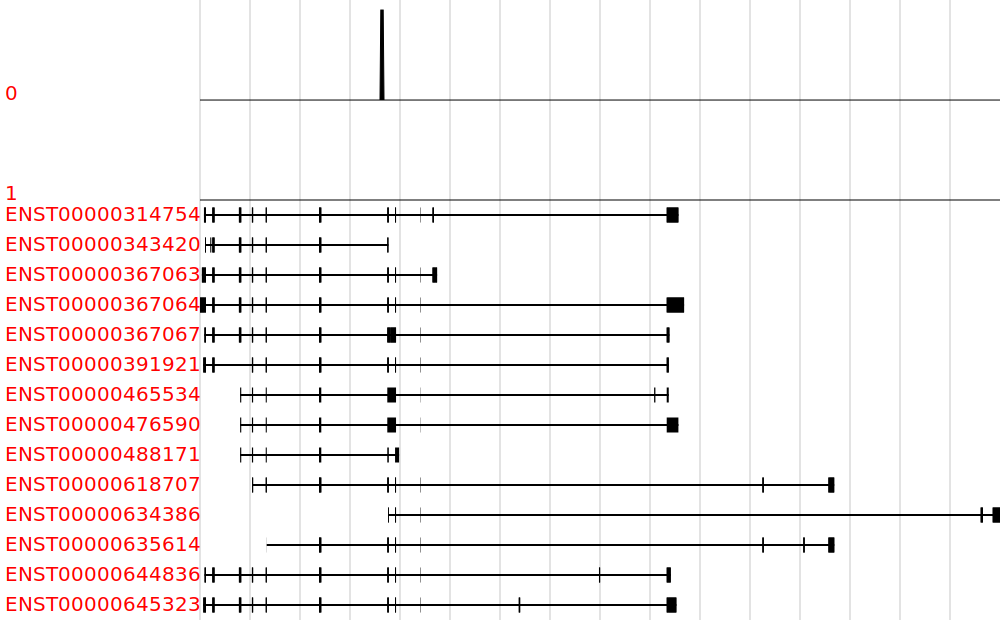

In [8]:
### Check our favourite genes, global pileup
v = cp.getView("CD55")

cp.pileup(v, 
          cellBC=adata.obs["origbc"].tolist(),  # subset on cell BCs
          cellFile=adata.obs["sampleid"].tolist(), 
          cellCluster=adata.obs["leiden"].tolist()  # Split into different tracks for clusters
         ).plot()


In [9]:


# # Test categorical 3D umap
# import scherlock
# scherlock.plot.plot_3d_umap_categorical(adata, "leiden")
# #scherlock.plot.plot_3d_umap_categorical(adata, "cellcycle", 
# #                         palette=['cornflowerblue', 'lemonchiffon', 'brown'])

In [10]:
############ Test side-by-side plotting
bdata=adata.copy()
sc.tl.umap(bdata, n_components=2)
scherlock.plot.plot_umaps_sidebyside(adata,bdata,save="out/sidebyside.html")

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
